In [1]:
import os
print(os.listdir('train/'))

['jasmine_leaves_healthy', 'jasmine_leaves_unhealthy', 'j_grandiflorum', 'j_sambac', 'r_damascena']


In [2]:
import pathlib
dir1 = 'train/'
dir2 = 'test/'

data_dir = pathlib.Path(dir1)
test_dir = pathlib.Path(dir2)



print(data_dir)
print(test_dir)


train
test


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import RandomFourierFeatures 
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

187


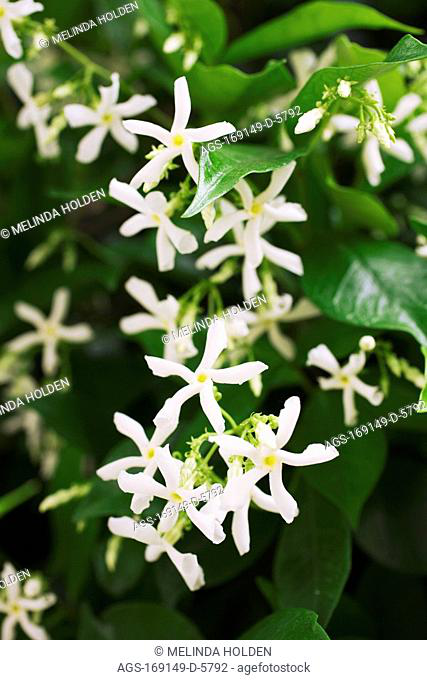

In [5]:
jasmine_grandiflorum = list(data_dir.glob('j_grandiflorum/*'))
PIL.Image.open(str(jasmine_grandiflorum[1]))

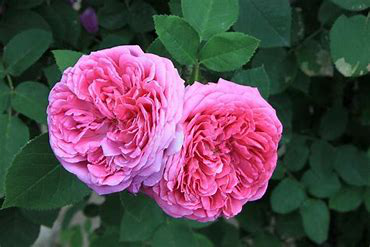

In [6]:
rosa_damascena = list(data_dir.glob('r_damascena/*'))
PIL.Image.open(str(rosa_damascena[2]))

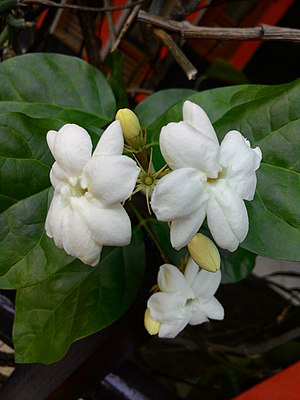

In [7]:

jsamine_sambac = list(data_dir.glob('j_sambac/*'))
PIL.Image.open(str(jsamine_sambac[4]))

In [20]:
batch_size = 5
img_height = 32
img_width =  32

In [28]:
# Pre-processing data with parameters.
train_datagen=ImageDataGenerator(rescale=1./256,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./256)

In [29]:
# set height and width and color of input image.
input_shape=(img_width,img_height,3)
batch_size =5
train_generator =train_datagen.flow_from_directory(dir1,
                                target_size=(img_width,img_height),                                                    batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),                                               batch_size=batch_size)

Found 236 images belonging to 5 classes.
Found 110 images belonging to 5 classes.


In [30]:
train_generator.class_indices

{'j_grandiflorum': 0,
 'j_sambac': 1,
 'jasmine_leaves_healthy': 2,
 'jasmine_leaves_unhealthy': 3,
 'r_damascena': 4}

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 236 files belonging to 5 classes.
Using 189 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 236 files belonging to 5 classes.
Using 47 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['j_grandiflorum', 'j_sambac', 'jasmine_leaves_healthy', 'jasmine_leaves_unhealthy', 'r_damascena']


InvalidArgumentError: slice index 5 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

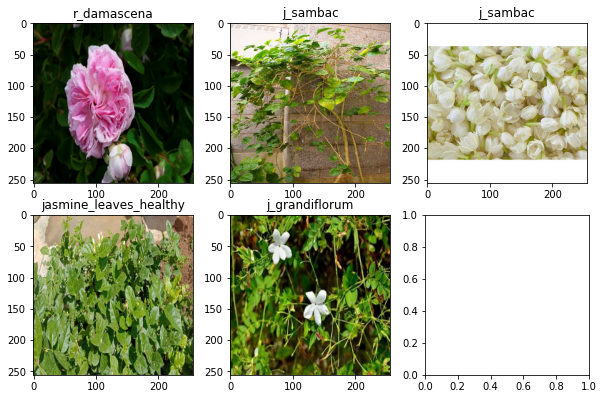

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10000000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./256)


In [44]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99609375


In [45]:
num_classes = len(class_names)
model_jasmine = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./256, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(2, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(4, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(246, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model_jasmine.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model_jasmine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 2)       98        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 4)       132       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
rlr = ReduceLROnPlateau(patience=10, verbose=10)
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=10)
mc = ModelCheckpoint('saved_model/testing_with_low_data_1.h5', save_best_only=True, verbose=1)

In [49]:
epochs=50
history = model_jasmine.fit(
  train_ds,
  callbacks=[ mc],   
  validation_data=val_ds,
  epochs=epochs,
  #steps_per_epoch =2
)

Epoch 1/50
6/6 [==============================] - 3s 460ms/step - loss: 1.4660 - accuracy: 0.4286 - val_loss: 1.3338 - val_accuracy: 0.5957

Epoch 00001: val_loss improved from inf to 1.33381, saving model to saved_model\testing_with_low_data_1.h5
Epoch 2/50
6/6 [==============================] - 2s 405ms/step - loss: 1.3216 - accuracy: 0.5344 - val_loss: 1.2850 - val_accuracy: 0.5957

Epoch 00002: val_loss improved from 1.33381 to 1.28499, saving model to saved_model\testing_with_low_data_1.h5
Epoch 3/50
6/6 [==============================] - 2s 404ms/step - loss: 1.2878 - accuracy: 0.5344 - val_loss: 1.2944 - val_accuracy: 0.5957

Epoch 00003: val_loss did not improve from 1.28499
Epoch 4/50
6/6 [==============================] - 3s 424ms/step - loss: 1.2760 - accuracy: 0.5344 - val_loss: 1.2519 - val_accuracy: 0.5957

Epoch 00004: val_loss improved from 1.28499 to 1.25194, saving model to saved_model\testing_with_low_data_1.h5
Epoch 5/50
6/6 [==============================] - 2s 403

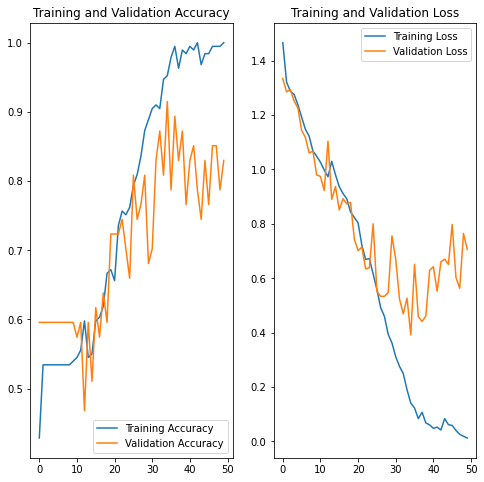

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.7)
])

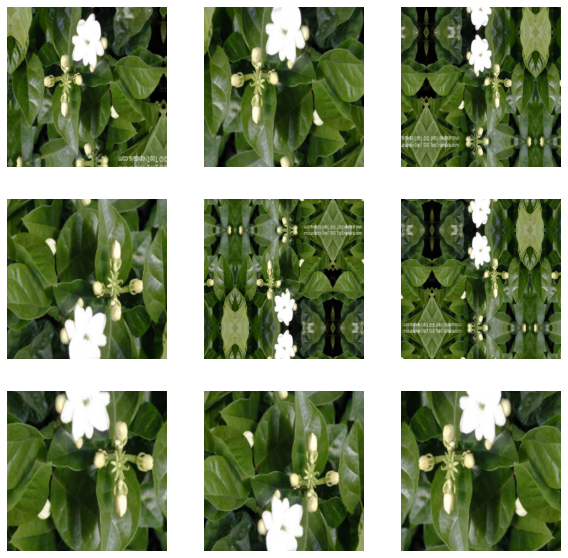

In [97]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [98]:
model_jasmine = Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(2, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(4, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(246, activation='tanh'),
  layers.Dense(num_classes, name="outputs")
])

In [99]:
model_jasmine.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
epochs = 5
history = model_jasmine.fit(
  train_ds,
  validation_data=val_ds,
      callbacks=[rlr, es, mc], 
  epochs=epochs,
  #steps_per_epoch = 5
)

Epoch 1/5
5/5 [==============================] - 1s 290ms/step - loss: 1.0056 - accuracy: 0.6053 - val_loss: 0.7935 - val_accuracy: 0.7568

Epoch 00001: val_loss did not improve from 0.50592
Epoch 2/5
5/5 [==============================] - 1s 279ms/step - loss: 0.9176 - accuracy: 0.6053 - val_loss: 0.9529 - val_accuracy: 0.7027

Epoch 00002: val_loss did not improve from 0.50592
Epoch 3/5
5/5 [==============================] - 1s 276ms/step - loss: 0.8782 - accuracy: 0.5461 - val_loss: 0.6556 - val_accuracy: 0.7297

Epoch 00003: val_loss did not improve from 0.50592
Epoch 4/5
5/5 [==============================] - 1s 284ms/step - loss: 0.9145 - accuracy: 0.6053 - val_loss: 0.8758 - val_accuracy: 0.6757

Epoch 00004: val_loss did not improve from 0.50592
Epoch 5/5
5/5 [==============================] - 1s 297ms/step - loss: 0.8045 - accuracy: 0.5658 - val_loss: 0.7302 - val_accuracy: 0.8108

Epoch 00005: val_loss did not improve from 0.50592


In [102]:
model_jasmine.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 2)       26        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 4)       36        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 16)       

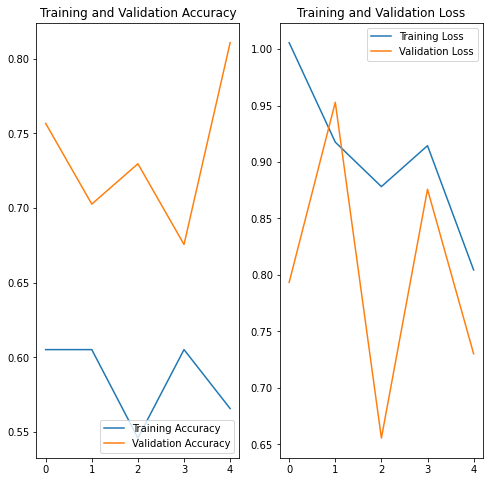

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 110 files belonging to 5 classes.


In [21]:
classes_names = test_ds.class_names
print(class_names)

['j_grandiflorum', 'j_sambac', 'jasmine_leaves_healthy', 'jasmine_leaves_unhealthy', 'r_damascena']


In [51]:
loaded_model = tf.keras.models.load_model('saved_model/testing_with_low_data_1.h5')
loaded_model.layers[1].input_shape #(None, 160, 160, 3)

(None, 256, 256, 3)

This image most likely belongs to j.healthy with a 86.95 percent confidence.


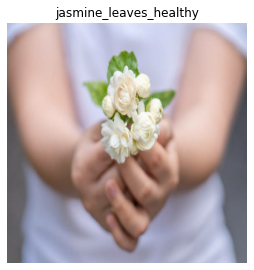

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(1,3,6):
    ax = plt.subplot(3, 3,i+1)
    plt.imshow(images[i].numpy().astype("uint8") )
    plt.title(class_names[labels[i]])
    predictions = loaded_model.predict(images,6,9 )
    score = tf.nn.softmax(predictions[1])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(classes_names[np.argmax(score)], 100* np.max(score)))

    plt.axis("off")

In [575]:
predictions.shape

(32, 5)

In [350]:
score2 = tf.nn.softmax(predictions)
score2

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[3.4967086e-01, 3.9971236e-02, 4.1203511e-01, 1.9832276e-01],
       [6.3344106e-02, 4.0239483e-02, 2.8923037e-03, 8.9352411e-01],
       [2.9992361e-02, 9.6919674e-01, 3.6583343e-04, 4.4502164e-04],
       [1.4886563e-01, 8.1598276e-01, 3.9456054e-03, 3.1206012e-02],
       [1.0565834e-01, 8.8836908e-01, 6.5287843e-04, 5.3197094e-03],
       [4.5709141e-02, 2.5583001e-02, 1.0310723e-03, 9.2767674e-01],
       [7.9987012e-02, 9.1299260e-01, 5.3796766e-04, 6.4824549e-03],
       [4.8273012e-01, 2.7737466e-01, 1.3665950e-02, 2.2622919e-01],
       [1.6436477e-01, 9.0626568e-02, 1.0542031e-02, 7.3446667e-01],
       [4.4871479e-01, 2.8237596e-01, 1.8382721e-02, 2.5052655e-01],
       [6.2416811e-02, 9.3568134e-01, 3.8827688e-04, 1.5135099e-03],
       [3.4033498e-01, 4.1078085e-01, 9.3322299e-02, 1.5556186e-01],
       [7.0189856e-02, 9.2761838e-01, 6.3544646e-04, 1.5563288e-03],
       [1.2943472e-01, 5.6630362e-02, 2.8964672e-03, 8

In [55]:
import tensorflow as tf

model = tf.keras.models.load_model('saved_model/testing_with_low_data_1.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("saved_model/another_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmp4np_fdwy\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmp4np_fdwy\assets


4744556